Here we want to explore the 10X data to see if we can 'find the ambient barcodes'

In [1]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import pysam
import regex
import glob
import CGAT.Fastq as Fastq
import CGAT.IOTools as IOTools
from datetime import datetime
%load_ext rpy2.ipython
%matplotlib inline  

In [2]:
bam_infile = "../run/raw/hgmm_100_possorted_genome_bam.bam"


In [3]:
def phredToInt(phreds):
    return(list(map(lambda x: ord(x)-33, phreds)))

qualities = collections.defaultdict(
    lambda: collections.defaultdict(collections.Counter))

read2genome = {}
genome2reads = collections.Counter()
cell_umi_counts = collections.defaultdict(set)
cell_counts = collections.Counter()
cell2species = collections.defaultdict(collections.Counter)
inbam = pysam.Samfile(bam_infile)
cell_counts_mapped = collections.defaultdict(collections.Counter)

n = 0
for read in inbam.fetch(until_eof=True):

    cell = read.get_tag('CR')
    umi = read.get_tag('UR') 
    
    if read.is_secondary:
        continue
    
    if read.is_unmapped:
        cell_counts_mapped[cell]['unmapped'] += 1
    else:
        cell_counts_mapped[cell]['mapped'] += 1
        
        species = read.reference_name.split("_")[0]
        genome2reads[species] += 1
    
        if read.query_name in read2genome:
            raise ValueError("read: %s already seen: %s\n%s" %(
                read.query_name, read2genome[read.query_name], read))
        else:
            read2genome[read.query_name] = species
        
    n+=1
    
    if n % 1000000 == 0:
        print("processed %iM reads %s" % (
            (float(n)/1000000), datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    
    cell_umi_counts[cell].add(umi)
    cell_counts[cell] += 1
    cell2species[cell][species] += 1
    
    qualities[cell]['read'].update(read.query_qualities)
    qualities[cell]['cell'].update(phredToInt(read.get_tag('CY')))
    qualities[cell]['umi'].update(phredToInt(read.get_tag('UY')))

print(genome2reads)
print(qualities['CTCGTACGTGCCTGCA'])

processed 1M reads 2017-08-17 10:13:07
processed 2M reads 2017-08-17 10:13:46
processed 3M reads 2017-08-17 10:14:23
processed 4M reads 2017-08-17 10:15:01
processed 5M reads 2017-08-17 10:15:39
processed 6M reads 2017-08-17 10:16:18
processed 7M reads 2017-08-17 10:16:55
Counter({'hg19': 4261776, 'mm10': 2577648})
defaultdict(<class 'collections.Counter'>, {'read': Counter({41: 153, 37: 114, 12: 75, 32: 74, 27: 39, 22: 34, 8: 1}), 'umi': Counter({41: 45, 37: 3, 32: 2}), 'cell': Counter({41: 50, 37: 18, 32: 10, 27: 1, 12: 1})})


In [4]:
print(cell_umi_counts["CTCGTACGTGCCTGCA"])

{'ATTTTCAGGG', 'TTGCTTCACT', 'GATCTAAGCA', 'GAAGACTCCC'}


In [5]:
def getCounterMean(counter):
    sum_of_numbers = sum([number*count for number, count in counter.most_common()])
    count = sum(count for n, count in counter.most_common())
    mean = sum_of_numbers / count
    return mean 

final_qualities = collections.defaultdict(lambda: collections.defaultdict(float))

for cell in qualities:
    try:
        final_qualities[cell]['read'] = getCounterMean(qualities[cell]['read'])
        final_qualities[cell]['cell'] = getCounterMean(qualities[cell]['cell'])
        final_qualities[cell]['umi'] = getCounterMean(qualities[cell]['umi'])
    except:
        print(cell)
        print(qualities['cell'])

In [6]:
rows = []
n = 0
for cell in cell_umi_counts:
    
    row = (cell, cell_counts[cell], len(cell_umi_counts[cell]),
           1-(len(cell_umi_counts[cell])/cell_counts[cell]))
    
    rows.append(row)

#print(cell_umi_counts)

In [7]:
duplication_df = pd.DataFrame.from_records(
    rows, columns=["cell", "count", "unique_umi_count", "dup._rate"])
print(duplication_df.head())
print(duplication_df.shape)
duplication_df = duplication_df[duplication_df['count']>10]
print(duplication_df.shape)
print(duplication_df.sort_values("count", ascending=False).head())

               cell  count  unique_umi_count  dup._rate
0  TTGCCGTCACGAAAGC      8                 4   0.500000
1  CCACGGACACCCATGG      7                 5   0.285714
2  TTCTTAGCATAAGACA      7                 6   0.142857
3  GGGCACTAGGTGCTTT      6                 5   0.166667
4  CTCTGGTGTGACGGTA      2                 1   0.500000
(194304, 4)
(23965, 4)
                    cell   count  unique_umi_count  dup._rate
81599   GACTGCGAGGGCATGT  121577             80663   0.336527
123338  GGTGCGTAGGCTACGA  110467             73916   0.330877
16002   ATGAGGGAGTAGTGCG  106446             70898   0.333953
124017  ACTGTCCTCATGCTCC  104794             70004   0.331985
102296  CGAACATTCTGATACG  104616             69370   0.336908


In [8]:
def getSpecificity(cell, cell2species, cell_counts):
    hg_counts = cell2species[cell]["hg19"]
    mm_counts = cell2species[cell]["mm10"]
    total = hg_counts + mm_counts
    assert total == cell_counts[cell]
    specificity = max(hg_counts, mm_counts) / (hg_counts + mm_counts)
    return specificity

def getAlignmentRate(cell, cell_counts_mapped, cell_counts):
    mapped = cell_counts_mapped[cell]["mapped"]
    unmapped = cell_counts_mapped[cell]["unmapped"]
    total = mapped + unmapped
    #if not total == cell_counts[cell]:
    #    print(cell, total, cell_counts[cell])
    #    raise ValueError()
    alignment = float(mapped)/total
    return alignment
                                   
print(cell2species['GACTGCGAGGGCATGT'])
print(getSpecificity('GACTGCGAGGGCATGT', cell2species, cell_counts))
print(getAlignmentRate('GACTGCGAGGGCATGT', cell_counts_mapped, cell_counts))

Counter({'hg19': 116850, 'mm10': 4727})
0.9611192906553049
0.9646067924031684


In [9]:
duplication_df['read_qual'] = [final_qualities[cell]['read'] for cell in duplication_df['cell']]
duplication_df['umi_qual'] = [final_qualities[cell]['umi'] for cell in duplication_df['cell']]
duplication_df['cell_qual'] = [final_qualities[cell]['cell'] for cell in duplication_df['cell']]
duplication_df['specificity'] = list(
    map(lambda x: getSpecificity(x, cell2species, cell_counts), duplication_df['cell']))
duplication_df['alignment_rate'] = [getAlignmentRate(x, cell_counts_mapped, cell_counts)
                                    for x in duplication_df['cell']]

In [10]:
print(duplication_df[duplication_df['cell']=='GACTGCGAGGGCATGT'])
print(duplication_df[duplication_df['cell']=='TTTATGCAGTTGTTGT'])
print(cell_counts_mapped['TTTATGCAGTTGTTGT'])
print(cell_counts['TTTATGCAGTTGTTGT'])


                   cell   count  unique_umi_count  dup._rate  read_qual  \
81599  GACTGCGAGGGCATGT  121577             80663   0.336527  35.095384   

        umi_qual  cell_qual  specificity  alignment_rate  
81599  40.174462  38.321448     0.961119        0.964607  
                    cell  count  unique_umi_count  dup._rate  read_qual  \
136396  TTTATGCAGTTGTTGT     27                26   0.037037  36.083144   

         umi_qual  cell_qual  specificity  alignment_rate  
136396  40.396296  38.409722          1.0        0.962963  
Counter({'mapped': 26, 'unmapped': 1})
27


In [11]:
def checkError(barcode, whitelist):
    near_matches = set()
    comp_regex = regex.compile("(%s){e<=1}" % barcode)
    comp_regex2 = regex.compile("(%s){e<=1}" % barcode[:-1])
    b_length = len(barcode)
    for whitelisted_barcode in whitelist:
        w_length = len(whitelisted_barcode)
        if barcode == whitelisted_barcode:
            continue
        if (max(b_length, w_length) > (min(b_length, w_length) + 1)):
            continue
        if comp_regex.match(whitelisted_barcode) or comp_regex2.match(whitelisted_barcode):
            near_matches.add(whitelisted_barcode)
            if len(near_matches) > 1:
                return near_matches

    return near_matches


In [12]:
def getWhitelistHard(duplication_df, n=100, return_set=True):
    whitelist = duplication_df.sort_values("count", ascending=False)[0:n]["cell"]
    if return_set:
        return set(whitelist)
    else:
        return whitelist.tolist()

whitelist = getWhitelistHard(duplication_df)
duplication_df['whitelist'] = [True if x in whitelist else False for x in duplication_df['cell']]
print(whitelist)
print(len(whitelist))

{'GGACGTCGTACTCGCG', 'CGATGGCAGCGTGTCC', 'GGAATAATCCCTGACT', 'TGCGGGTCAGACGCAA', 'TCGCGAGGTTCAGACT', 'CTCGGGAGTGGCCCTA', 'AACTCTTAGGAACTGC', 'GGATTACAGCTAGGCA', 'TCTTCGGCAGACGTAG', 'CCTCAGTCATGGGAAC', 'AGAGCTTGTTCTCATT', 'CTCGAGGAGAGCCCAA', 'GGATTACCATGCAACT', 'TTTGCGCCAAGTCTGT', 'CTCAGAAAGACCCACC', 'CTGGTCTTCGGTTAAC', 'GCTTCCAGTCCGAGTC', 'CTTGGCTCAGGGAGAG', 'AAAGATGAGAAACGAG', 'GATCGTATCTAAGCCA', 'GTTTCTACAAGGTTCT', 'ATCACGAGTAATTGGA', 'CGAACATTCTGATACG', 'TAGGCATTCGTTGCCT', 'GCATACAAGTGAACAT', 'AGCGTCGTCCGCGTTT', 'ACTGTCCCATATGGTC', 'CGATTGATCAACCAAC', 'ACAGCCGTCCCTTGTG', 'AGCGTCGGTAAACACA', 'CGGACGTCAATCGAAA', 'CAAGATCTCCGTCAAA', 'CGGAGTCCAGCCAGAA', 'ATTACTCTCGGATGGA', 'CCTTCGAGTGACTACT', 'TGACTAGGTGTGGTTT', 'ATTGGTGTCTCAAGTG', 'TACACGAAGGCAAAGA', 'TCAGCTCGTGACCAAG', 'TTTATGCAGTTGTCGT', 'CATTATCCATCGACGC', 'TGAGGGATCCTCTAGC', 'CAGATCATCGTCGTTC', 'ACTGTCCTCATGCTCC', 'GCTGCGACAGAGCCAA', 'CTAACTTTCTATCCCG', 'GTAACTGAGTGAAGTT', 'GACTGCGAGGGCATGT', 'CACCTTGTCAGTTCGA', 'GGTGCGTAGGCTACGA',

In [14]:
from itertools import chain

def getErrorFreq(barcodes, whitelist):
    
    error = {}
    error["Error off whitelist"] = 0
    error["Error off (multiple) whitelist"] = 0 
    error["Error off (multiple) whitelist"] = 0
    error["No error"] = 0
    
    for barcode in barcodes:
        barcode_errors = checkError(barcode, whitelist)
    
        if len(barcode_errors) > 0:
            if len(barcode_errors) == 1:
                error["Error off whitelist"] += 1
            elif len(barcode_errors) == 2:
                error["Error off (multiple) whitelist"] += 1
            else:
                error["Error off (multiple) whitelist"] += 1
        else:
            error["No error"] += 1

    return error

sorted_duplication_df = duplication_df.sort_values(by="unique_umi_count", ascending=False)

rows = []
columns = ["threshold", "above_threshold",
           "Error_class", "count", "fraction"]

for whitelist_threshold in chain(range(30,200,1), range(200,1000,25)):
    whitelist_barcodes = sorted_duplication_df['cell'][0:whitelist_threshold].tolist()
    
    n_nearly_barcodes = min(100, int(whitelist_threshold * 0.25))
    nearly_barcodes = sorted_duplication_df['cell'][
        whitelist_threshold:whitelist_threshold + n_nearly_barcodes]
    
    lower_error = getErrorFreq(nearly_barcodes, whitelist_barcodes)
    
    for k,v in lower_error.items():
        rows.append([whitelist_threshold, 0, k, v, v/n_nearly_barcodes])

    upper_error = getErrorFreq(whitelist_barcodes[-(n_nearly_barcodes):], whitelist_barcodes)
    
    for k,v in upper_error.items():
        rows.append([whitelist_threshold, 1, k, v, v/n_nearly_barcodes])


errors_df = pd.DataFrame.from_records(rows, columns=columns)
print(errors_df.head())


   threshold  above_threshold                     Error_class  count  fraction
0         30                0             Error off whitelist      0       0.0
1         30                0                        No error      7       1.0
2         30                0  Error off (multiple) whitelist      0       0.0
3         30                1             Error off whitelist      0       0.0
4         30                1                        No error      7       1.0


In [15]:
no_errors_df = errors_df[errors_df['Error_class']=="No error"]
print(no_errors_df[no_errors_df['fraction']<0.99].head())

     threshold  above_threshold Error_class  count  fraction
421        100                0    No error     24  0.960000
427        101                0    No error     24  0.960000
433        102                0    No error     24  0.960000
439        103                0    No error     24  0.960000
445        104                0    No error     24  0.923077


  threshold above_threshold                    Error_class count fraction
0        30               0            Error off whitelist     0        0
1        30               0                       No error     7        1
2        30               0 Error off (multiple) whitelist     0        0
3        30               1            Error off whitelist     0        0
4        30               1                       No error     7        1
5        30               1 Error off (multiple) whitelist     0        0


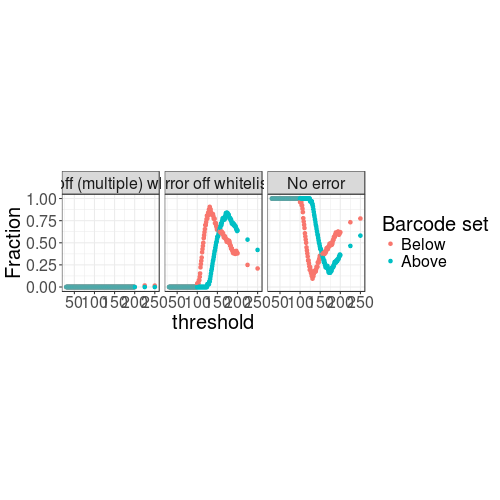

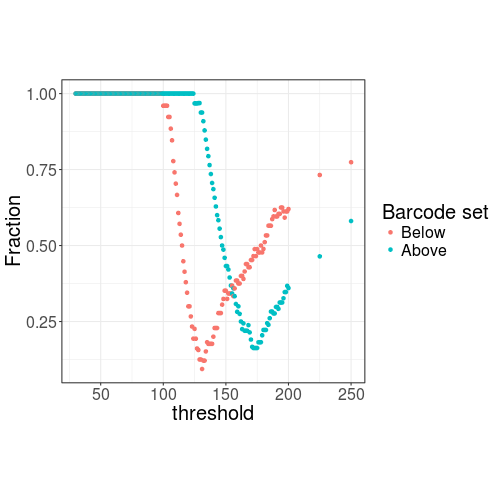

In [18]:
%%R -i errors_df -w 500 -h 500
library(ggplot2)
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)
print(head(errors_df))

p <- ggplot(errors_df,
            aes(threshold, fraction, colour=as.factor(above_threshold))) +
geom_point() + my_theme + facet_wrap(~Error_class) + xlab("threshold") + ylab("Fraction") + 
scale_colour_discrete(name="Barcode set", labels=c("Below", "Above")) +
coord_cartesian(xlim=c(30,250))

print(p)

p <- ggplot(errors_df[errors_df$Error_class=="No error",],
            aes(threshold, fraction, colour=as.factor(above_threshold))) +
geom_point() + my_theme + xlab("threshold") + ylab("Fraction") + 
scale_colour_discrete(name="Barcode set", labels=c("Below", "Above")) +
coord_cartesian(xlim=c(30,250))

print(p)



  threshold above_threshold n_top_barcodes                    Error_class count
0        30               0             24                       No error     6
1        30               0             24            Error off whitelist     0
2        30               0             24 Error off (multiple) whitelist     0
3        30               1             24                       No error    24
4        30               1             24            Error off whitelist     0
5        30               1             24 Error off (multiple) whitelist     0
  fraction
0        1
1        0
2        0
3        1
4        0
5        0


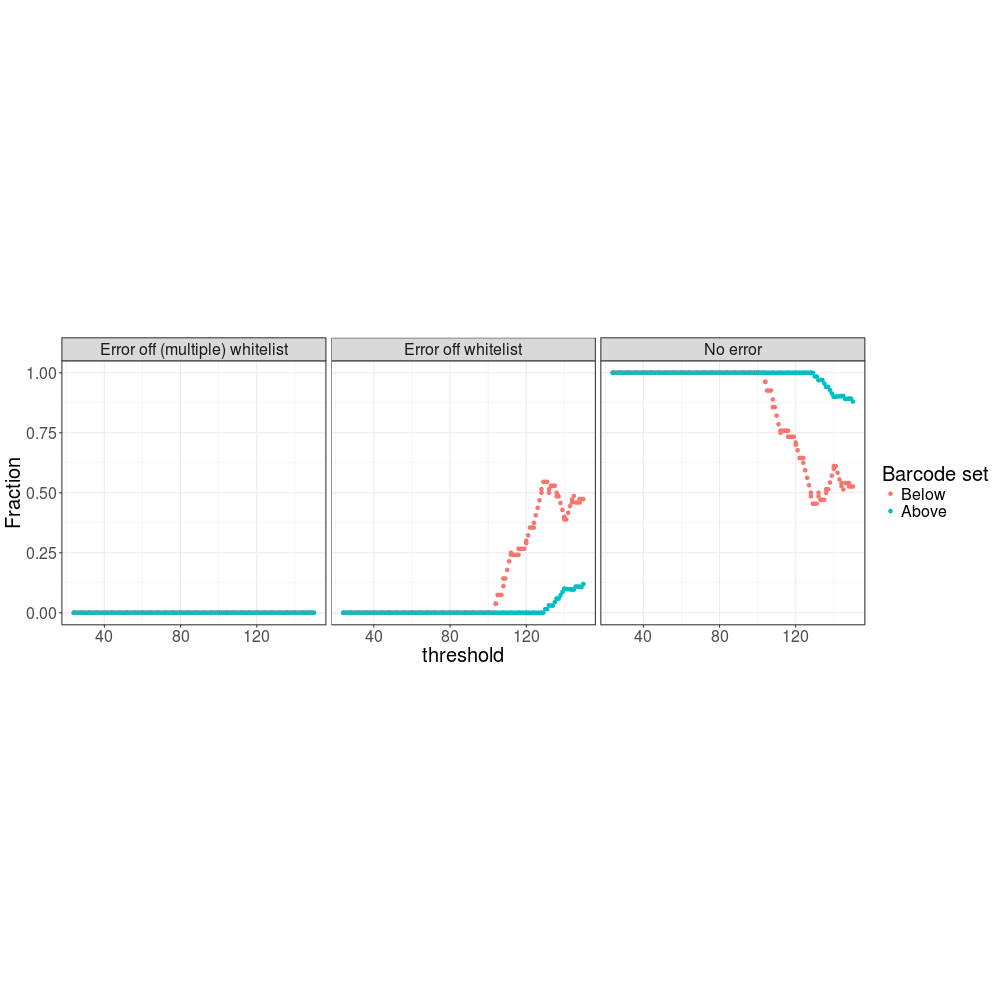

In [78]:
%%R -i errors_df -w 1000 -h 1000
library(ggplot2)
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)
print(head(errors_df))

p <- ggplot(errors_df[errors_df$n_top_barcodes<=150,], aes(n_top_barcodes, fraction, colour=as.factor(above_threshold))) +
geom_point() + my_theme + facet_wrap(~Error_class) + xlab("threshold") + ylab("Fraction") + 
scale_colour_discrete(name="Barcode set", labels=c("Below", "Above"))
print(p)




In [207]:
error = []
error_barcode = []

n = 0
for barcode in duplication_df['cell']:
    n+=1
    if n % 10000 == 0:
        print("processed %i cell barcodes" % n)
    barcode_errors = checkError(barcode, whitelist)
    
    if len(barcode_errors) > 0:
        if len(barcode_errors) == 1:
            error_barcode.append(list(barcode_errors)[0])
            error.append("Error off whitelist")
        elif len(barcode_errors) == 2:
            error_barcode.append(list(barcode_errors)[0])
            error.append("Error off (multiple) whitelist")
        else:
            error_barcode.append("")
            error.append("Error off (multiple) whitelist")
    
    else:
        error.append("")
        error_barcode.append("")               
    
duplication_df['full_error'] = error
duplication_df['error_barcode'] = error_barcode

processed 10000 cell barcodes
processed 20000 cell barcodes


In [208]:
print(collections.Counter(duplication_df['full_error']))

Counter({'': 20266, 'Error off whitelist': 3699})


In [209]:
print(sum(duplication_df[duplication_df['whitelist']==True]['count']))
print(sum(duplication_df[duplication_df['full_error']=='Error off whitelist']['count']))

5963891
128224


In [210]:
%%R -i duplication_df

suppressMessages(library(ggplot2))
suppressMessages(library(Hmisc))

print(head(duplication_df))


               cell count unique_umi_count dup._rate read_qual umi_qual
2  GGTCGTAGGCTACGAC    48               33 0.3125000  35.10034 40.23125
17 ACTTACTTCTTCTGGC    23               15 0.3478261  35.40284 39.94783
23 TTAGGACTCCGAACGC    11                8 0.2727273  37.13822 41.00000
35 AAAGCAAGTACCGGCT    11                9 0.1818182  35.95083 39.66364
40 TCAGCTCAGCTAGCCC    12               10 0.1666667  37.54167 40.93333
52 GTTCTCGGTTGATTGC    16               14 0.1250000  32.71429 40.77500
   cell_qual specificity alignment_rate whitelist          full_error
2   38.26302   1.0000000      1.0000000     FALSE Error off whitelist
17  38.31793   0.6086957      0.9565217     FALSE                    
23  39.12500   0.9090909      0.9090909     FALSE                    
35  38.81818   0.6363636      0.8181818     FALSE                    
40  39.03125   0.7500000      0.8333333     FALSE                    
52  38.72656   0.6250000      1.0000000     FALSE                    
      

In [211]:
%%R
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)


[1] 4.276485


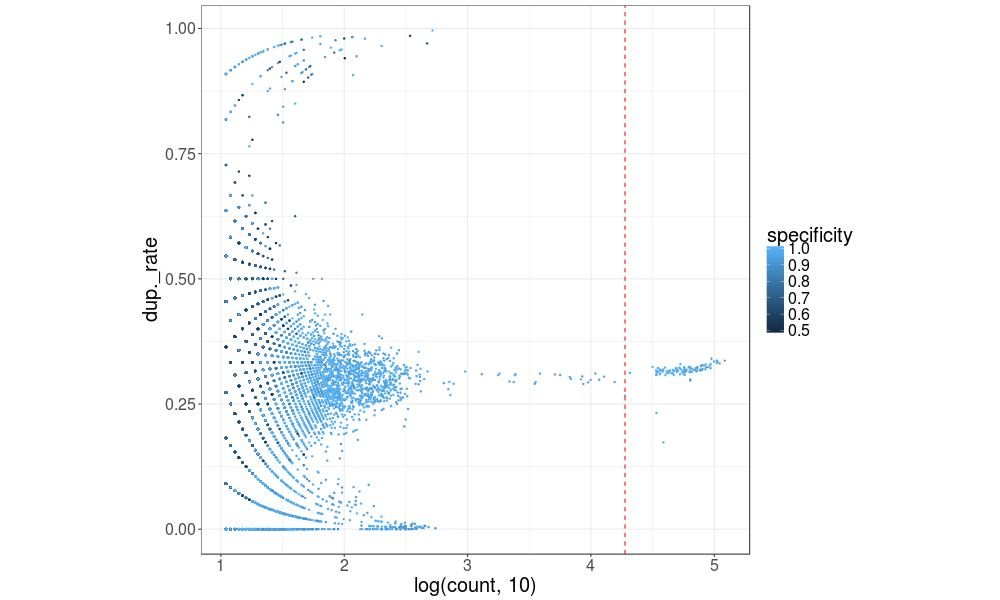

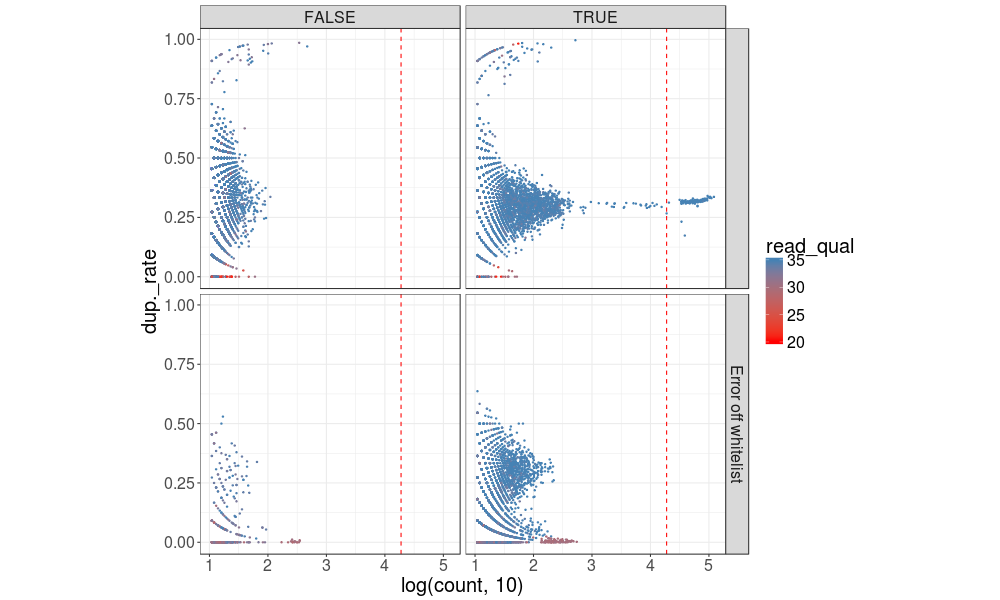

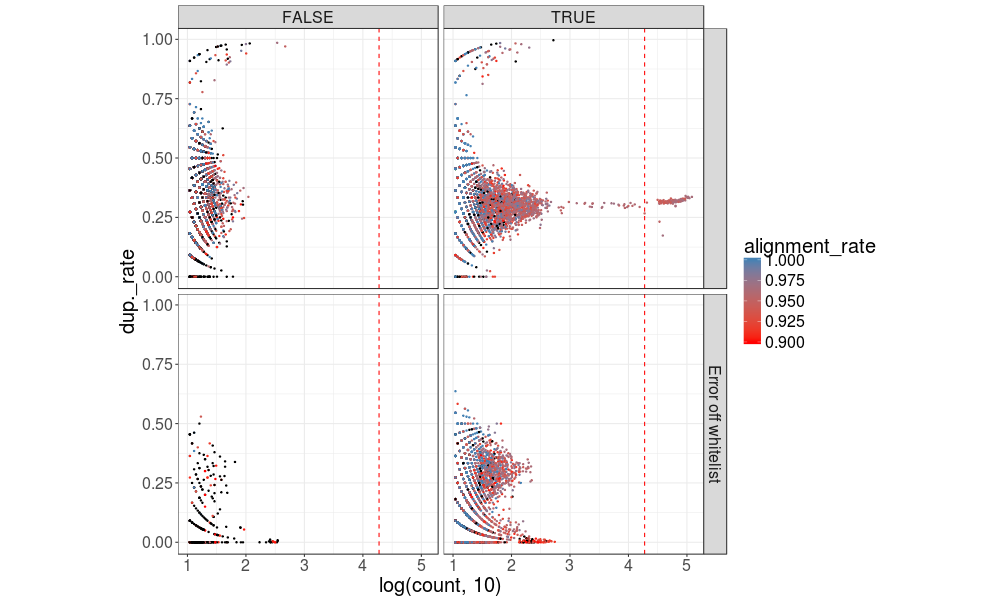

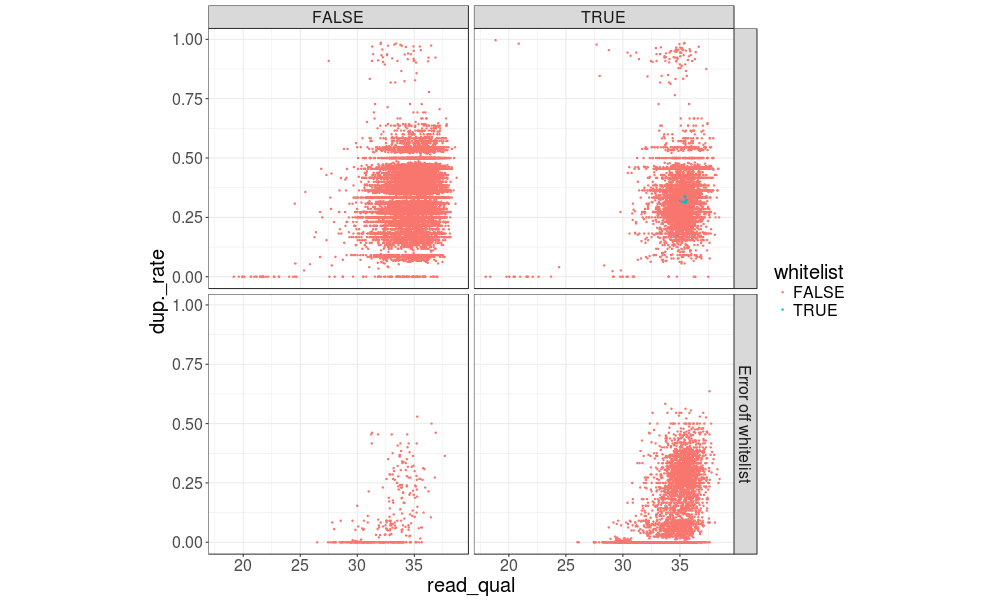

In [213]:
%%R -w 1000 -h 600
duplication_df$specificity_binary <- duplication_df$specificity > 0.9

threshold = duplication_df[order(-duplication_df$count), "count"][100]
threshold_umi = duplication_df[order(-duplication_df$unique_umi_count), "unique_umi_count"][100]
print(log(threshold, 10))

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=specificity)) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2)

print(p) 

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=read_qual)) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
facet_grid(full_error~specificity_binary) +
scale_colour_continuous(low="red", high="steelblue", limits=c(20,35), na.value="steelblue")

print(p) 

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=alignment_rate)) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
facet_grid(full_error~specificity_binary) +
scale_colour_continuous(low="red", high="steelblue", limits=c(0.9,1), na.value="black")

print(p) 

p <- ggplot(duplication_df, aes(read_qual, dup._rate, colour=whitelist)) +
geom_point(size=0.5) + my_theme  +
facet_grid(full_error~specificity_binary)

print(p) 

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density(adjust = 5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(2,5), ylim=c(0,0.05))

#print(p) 



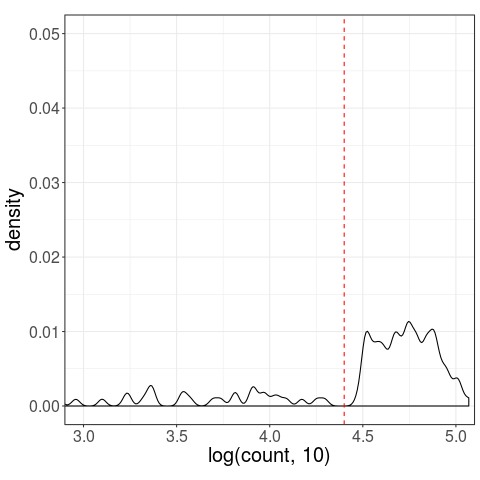

In [65]:
%%R
manual_threshold = 10^4.4
duplication_df$knee <- duplication_df$count > manual_threshold

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density() + my_theme  +
geom_vline(xintercept=log(manual_threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(3,5), ylim=c(0,0.05))

print(p) 


                   cell  count unique_umi_count dup._rate read_qual umi_qual
124391 GACTGCGAGGGCATGT 117274            78502 0.3306104  35.49284 40.21529
56197  GGTGCGTAGGCTACGA 106850            72021 0.3259616  35.56681 40.18307
18340  ATGAGGGAGTAGTGCG 102713            68939 0.3288191  35.48508 40.20737
150086 ACTGTCCTCATGCTCC 101356            68264 0.3264928  35.66609 40.28047
10620  CGAACATTCTGATACG 101163            67616 0.3316133  35.99524 40.24140
166412 ACTGTCCCATATGGTC  95643            64111 0.3296843  35.88246 40.27911
       cell_qual knee x    cum
124391  38.36049 TRUE 1 117274
56197   38.32755 TRUE 2 224124
18340   38.22048 TRUE 3 326837
150086  38.39798 TRUE 4 428193
10620   38.62028 TRUE 5 529356
166412  38.46758 TRUE 6 624999
                   cell count unique_umi_count dup._rate read_qual umi_qual
170297 GTGGGTCCATCCCACT    11                6 0.4545455   36.0102 40.37273
       cell_qual  knee     x     cum
170297  38.16477 FALSE 21160 6359763
[1] 5671215


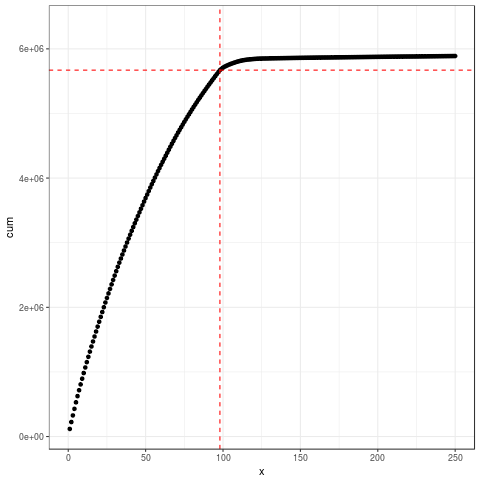

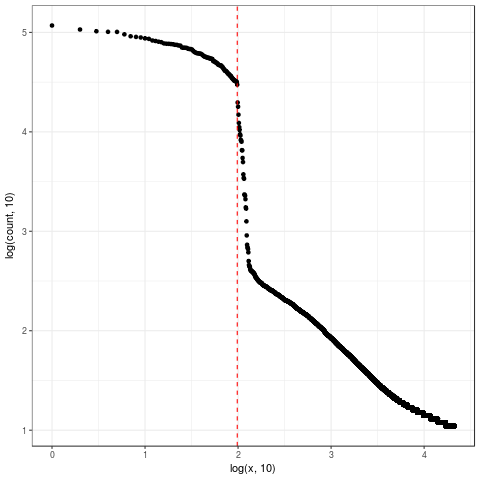

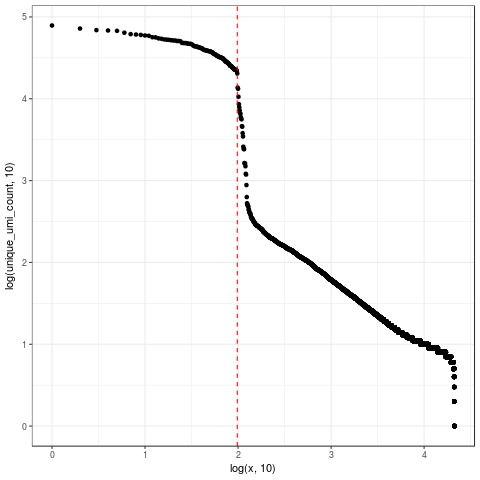

In [66]:
%%R
tmp_df <- duplication_df[order(-duplication_df$count),]
tmp_df$x <- seq(1, length(tmp_df[,1]))
tmp_df$cum <- cumsum(tmp_df$count)

tmp_df2 <- duplication_df[order(-duplication_df$unique_umi_count),]
tmp_df2$x <- seq(1, length(tmp_df2[,1]))
tmp_df2$cum <- cumsum(tmp_df2$unique_umi_count)

print(head(tmp_df))

print(tmp_df[tmp_df$x==length(tmp_df$count>manual_threshold),])

threshold_y_cum = sum(tmp_df[tmp_df$knee==TRUE, "count"])
print(threshold_y_cum)
threshold_x_cum = sum(tmp_df$knee==TRUE)

p <- ggplot(tmp_df, aes(x, cum)) + geom_point() + theme_bw() + xlim(0, 250) +
geom_hline(yintercept=threshold_y_cum, linetype=2, colour="red") +
geom_vline(xintercept=threshold_x_cum, linetype=2, colour="red")
print(p)


p <- ggplot(tmp_df, aes(log(x,10), log(count,10))) + geom_point() + theme_bw() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)

p <- ggplot(tmp_df2, aes(log(x,10), log(unique_umi_count,10))) + geom_point() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)
